# Mapper dashboard demo

In this notebook we present a first demo of a Mapper dashboard. The experiment in the notebook is a reproduction of the papers of Carlsson and Gabrielsson. In the first part of their experiment the authors found the "primary circle" of line and edge detectors as a topological feature of the weight vector space of a Convolutional Neural Network (CNN). The ability to see natural images as patches of lines and edges is similar to to how the mammalian primary visual cortex decodes the signal from the optical nerve. 

In short we first train 100 Convolutional Neural Networks with a depth of 64 feature maps in the first hidden layer. For each network we save the $3 \times 3$ shared weight matrix, one for each feature map. For all networks we have 6400 9-dimensional points. These points are density filtered, which means that we use 200-th nearest neighbour as a density estimator to select 30 per cent of the "most dense" or nearest points in the point cloud. 

After density filtration we have 1920 nine-dimensional points, to which we apply PCA as a data lens for the Mapper complex. With the first two PCA components we generate the Giotto Mapper complex. When hovering over each node in the Mapper complex we compute and present the mean of the weight matrices wich reside in that node. 

Can we reproduce the primary circle from the papers using open source software?

In [13]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module
import utils.mapper_dashboard as md

# Scikit tools
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Plotly stuff
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import HTML, HBox, VBox, Image, Layout

# tda magic
from gtda.mapper.cluster import FirstSimpleGap
from gtda.mapper.cluster import FirstHistogramGap

from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
)

from gtda.mapper.utils.visualization import set_node_sizeref

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Importing the point cloud of 9-dimensional weight vectors and inspecting the first samples.

In [14]:
weights_file_path = './data/weights_100n_86e.npy'
weights_file_path
weight_array_raw = np.load(weights_file_path)
weight_array = np.reshape(weight_array_raw, (-1, 9))
print(np.shape(weight_array))
point_cloud = md.get_density_filtered_point_cloud(weight_array, 200, 0.3, user_axis=1)
point_cloud_frame = pd.DataFrame(point_cloud)
point_cloud_frame.head()

,0,1,2,3,4,5,6,7,8
0,0.814837,0.718308,1.570937,-0.099020,0.647377,0.041458,-1.365455,-1.580348,-0.748093
1,0.782809,0.698520,1.562040,0.004134,0.794680,-0.112282,-1.558499,-1.205612,-0.965790
2,0.810461,0.425757,1.312548,0.209003,0.995998,0.121297,-1.221192,-1.760447,-0.893425
3,1.239135,0.681464,0.995881,0.012283,0.664284,0.292534,-0.924513,-1.828877,-1.132192
4,0.887236,0.572814,1.200834,-0.543494,0.884385,0.755803,-1.461055,-1.253712,-1.042812


## Generating the Mapper complex

First we define the data lens as the two first components of the PCA, and plot the transformed point cloud.

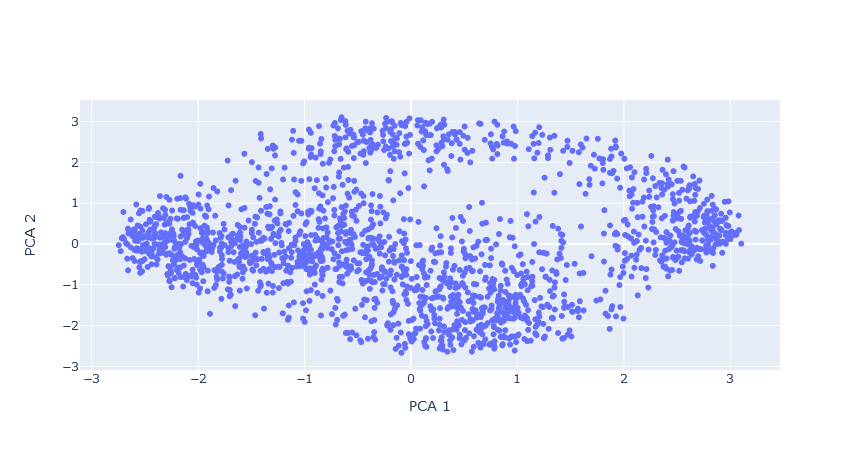

In [15]:
data_lens_a = PCA(n_components=2)
data_lens_a.fit(point_cloud)
print(np.shape(data_lens_a))
print(data_lens_a.explained_variance_)
print(data_lens_a.explained_variance_ratio_)

transformed_point_cloud = data_lens_a.transform(point_cloud)
x_a = transformed_point_cloud[:][:, 0]
y_a = transformed_point_cloud[:][:, 1]
print(np.shape(transformed_point_cloud))

fig = go.Figure(data=[go.Scatter(x=x_a, y=y_a, mode='markers')])
fig.update_xaxes(title_text='PCA 1')
fig.update_yaxes(title_text='PCA 2')
fig.show()

We define a clustering method for the Mapper pipeline. Then we pull back the covering of the PCA lens into the point cloud. Note that we scale the features of the point cloud as a modification of the Euclidean clustering metric.

In [16]:
clustering_method = FirstSimpleGap(relative_gap_size=0.7,
                                  max_fraction=0.9,
                                  linkage='single')

from sklearn.preprocessing import StandardScaler
clustering_scaler = StandardScaler(with_mean=False)

# configure Mapper pipeline
pipeline_vne = make_mapper_pipeline(
    filter_func=data_lens_a,
    cover=CubicalCover(n_intervals=30, overlap_frac=0.66),
    clustering_preprocessing=clustering_scaler,
    clusterer=clustering_method,
    verbose=True,
    n_jobs=4)
graph_a = pipeline_vne.fit_transform(point_cloud)

Here we extract node metadata from the Mapper graph, and then generate the visualization of the Mapper complex. 

In [17]:
node_id, node_elements = graph_a['node_metadata']['node_id'], \
    graph_a['node_metadata']['node_elements']
plotly_kwargs = {
    'node_trace_marker_colorscale':'YlOrRd',
    #"node_trace_marker_sizeref": set_node_sizeref(node_elements, node_scale=25)
}

colors = np.asarray([np.shape(node_elements[i]) for i in range(len(node_elements))])
colors = np.squeeze(colors)

# initialise and display figure
fig_mapper = plot_static_mapper_graph(pipeline_vne, 
                               point_cloud,
                               layout='auto',
                               layout_dim=2,
                               plotly_kwargs=plotly_kwargs,
                               color_by_columns_dropdown=False,
                               node_color_statistic=colors)
# display figure
# fig.show(config={"scrollZoom": True})

In [18]:
scatter = fig_mapper.data[1]

In [19]:
import sys
sys.stdout = open(1, 'w')

## Building the Mapper dashboard

First we introduce a dummy 3 by 3 matrix as a placeholder in the dashboard

In [20]:
img_rgb = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[0, 255, 0], [0, 0, 255], [255, 0, 0]],
                    [[0, 255, 255], [255, 0, 255], [0, 255, 0]]
                   ], dtype=np.uint8)
print(np.shape(img_rgb))
fig_weights = go.FigureWidget(go.Image(z=img_rgb))

We initialize a Ipywidget for the feature value dash

In [21]:
node_stats = HTML()

# Config for to_html() is Pandas, not Plotly or ipywidgets
pandas_config={'titleText': True}

The following function is called each time the user hovers over a node in the Mapper complex. Returns the mean weight image and the mean feature values.

In [22]:
def hover_node_stats(trace, points, state):
    #ipdb.set_trace()
    ind = points.point_inds
    indices = node_elements[int(ind[0])]
    samples = point_cloud_frame.iloc[indices]
    x_mean = samples.mean()
    x_mean.name = 'Mean values of features'
    node_stats.value = x_mean.to_frame().to_html(header=True)
    #computing mean weights
    spatial_map_matrix = x_mean.to_numpy().reshape(3, 3)
    spatial_map_matrix = np.stack((spatial_map_matrix,)*3, axis=-1)
    spatial_map_matrix = (255*(spatial_map_matrix - spatial_map_matrix.min()) / (spatial_map_matrix.max() - spatial_map_matrix.min())).astype('uint8')
    fig_weights.data[0].z =spatial_map_matrix

#ipdb.pm()
scatter.on_hover(hover_node_stats)

For flexibility (no pun) we can have a layout specification for the dashboard components

In [23]:
v_box_layout = Layout(display='flex',
                      flex_flow='row',
                      align_items='center',
                      justify_content='center',
                      width='80%')

## Presenting the Mapper dashboard

Now we can plot the Mapper complex, mean feature values and mean weights for each node.

In [24]:
dashboard = VBox([fig_mapper, 
                  HBox([node_stats, fig_weights], layout=v_box_layout)
                 ])
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'widt…